In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/Project_A_Supp')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [4]:
train_dir = '/content/drive/My Drive/Project_A_Supp/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/Project_A_Supp/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [5]:
model=load_model('models/HMT.h5',compile=False)

In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [6]:
from xai_utils import *

Load a batch of images

In [7]:
test_generator.reset()

In [8]:
image_batch,label_batch=test_generator.next()

Classes:

In [9]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']

Predict a single image

In [10]:
index=31

In [11]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9945245


0
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.99911827
1
True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.2342313
2
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.91822964
3
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.98777974
4
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.84578747
5
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.95737284
6
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9562981
7
True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.0811346
8
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9917345
9
True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9880028
10
True label: Tumor
Predicted_label: Tumor
Confidence score 

Text(0.5, 1.0, 'Sample image of Tumor(Confidence 0.0811346)')

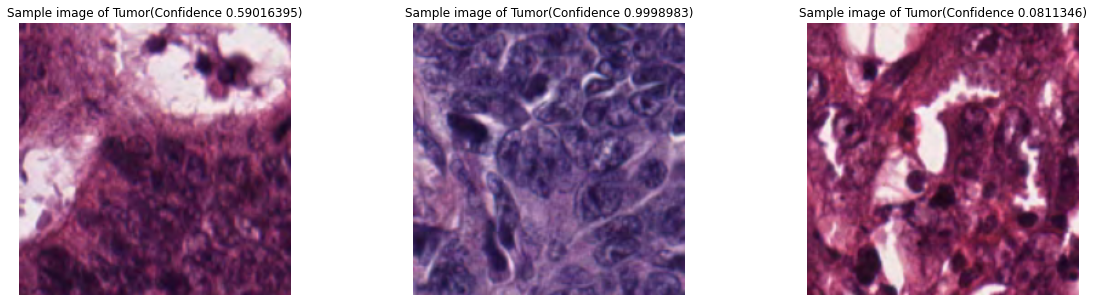

In [12]:
# plotting examples of classification
# Sample test set
test_generator.reset()
for i in range(2):
  image_batch,label_batch=test_generator.next()
prediction=model(image_batch)

for y in range(prediction.shape[0]):
  print(y)
  print('True label: '+classes[np.argmax(label_batch[y])])
  print('Predicted_label: '+classes[np.argmax(prediction[y])])
  print('Confidence score for the correct label: '+str(prediction[y][np.argmax(label_batch[y])].numpy()))


i1=10
i2=24
i3=7

#plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(image_batch[i1])
plt.axis('off')
plt.title('Sample image of ' + classes[label_batch[i1].argmax()]+'(Confidence ' +str(prediction[i1][np.argmax(label_batch[i1])].numpy())+')')

plt.subplot(1,3,2)
plt.imshow(image_batch[i2])
plt.axis('off')
plt.title('Sample image of ' + classes[label_batch[i2].argmax()]+'(Confidence ' +str(prediction[i2][np.argmax(label_batch[i2])].numpy())+')')

plt.subplot(1,3,3)
plt.imshow(image_batch[i3])
plt.axis('off')
plt.title('Sample image of ' + classes[label_batch[i3].argmax()]+'(Confidence ' +str(prediction[i3][np.argmax(label_batch[i3])].numpy())+')')

# Plotting Training Progress

In [13]:
#Create prediction and true label sets
test_generator.reset()
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
prediction_set = prediction
label_set = label_batch
for i in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    prediction_set = tensorflow.concat([prediction_set,prediction], axis=0)
    label_set = np.concatenate((label_set,label_batch), axis=0)
prediction_set=prediction_set.numpy()
pred_prob = prediction_set
label_prob = label_set
prediction_set = prediction_set.argmax(axis=1)
label_set = label_set.argmax(axis=1)

In [ ]:
#3.b overall classification accuracy on test set
acc = 1*(prediction_set == label_set)
accuracy = acc.sum() / prediction_set.size
print(accuracy)

0.8346774193548387



Class Accuracies: 
[0.85483871 0.75806452 0.77419355 0.85483871 0.66129032 0.82258065
 0.9516129  1.        ]


Text(0.5, 1.0, 'Accuracy per Class')

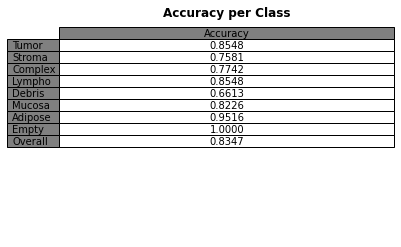

In [ ]:
#3.c classwise classification accuracy
correct_classification = np.zeros(8)
occurrences = 496/8

for x in range(496) :
  if label_set[x] == prediction_set[x] :
    correct_classification[label_set[x]] += 1

class_accuracy = np.divide(correct_classification,occurrences)
print('\nClass Accuracies: ')
print(class_accuracy)

labels = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty', 'Overall']
content = np.transpose(np.append(class_accuracy,accuracy))
content = [['%.4f' %i] for i in content]

fig, ax = plt.subplots()
ax.set_axis_off() 
table = ax.table( 
    cellText = content,  
    rowLabels = labels,  
    colLabels = ['Accuracy'], 
    rowColours =["grey"] * 9,  
    colColours =["grey"] * 2,
    cellLoc ='center',  
    loc ='upper center')         
ax.set_title('Accuracy per Class', 
             fontweight ="bold") 

In [ ]:
#3.d ROC and AUC curves
class_auc = np.zeros(8)
ns_auc = np.zeros(8)
ns_prob = np.zeros(496)
for x in range(8):
  ns_auc[x] = metrics.roc_auc_score(label_prob[:,x], ns_prob)
  class_auc[x] = metrics.roc_auc_score(label_prob[:,x], pred_prob[:,x])

content = np.transpose(class_auc)
content = [['%.4f' %i] for i in content]

fig, ax = plt.subplots()
ax.set_axis_off() 
table = ax.table( 
    cellText = content,  
    rowLabels = classes,  
    colLabels = ['ROC AUC'], 
    rowColours =["grey"] * 8,  
    colColours =["grey"] * 2, 
    cellLoc ='center',  
    loc ='upper center')         
ax.set_title('ROC AUC per Class', 
             fontweight ="bold") 

#calculate roc curves
fig, ax = plt.subplots()
for c in range(8):
  ns_fpr, ns_tpr, _ = metrics.roc_curve(label_prob[:,c], ns_prob)
  lr_fpr, lr_tpr, _ = metrics.roc_curve(label_prob[:,c], pred_prob[:,c])
  # plot the roc curve for the model
  print('')
  plt.title('ROC Curve for Class ' + classes[c])
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

[[53  0  7  1  0  1  0  0]
 [ 0 47  5  0  9  1  0  0]
 [ 0 10 48  2  2  0  0  0]
 [ 2  0  7 53  0  0  0  0]
 [ 0 20  0  0 41  1  0  0]
 [ 2  0  5  1  3 51  0  0]
 [ 0  0  0  0  0  0 59  3]
 [ 0  0  0  0  0  0  0 62]]


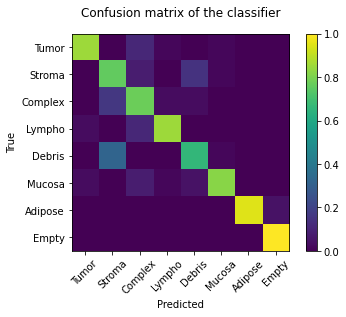

In [14]:
#3.e normalized confusion matrix
confusion_matrix = metrics.confusion_matrix(label_set, prediction_set)
print(confusion_matrix)
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)
#plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes,rotation=45)
ax.set_yticklabels([''] + classes)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Text(0.5, 1.0, 'Precision, Recall and F1 values per Class')

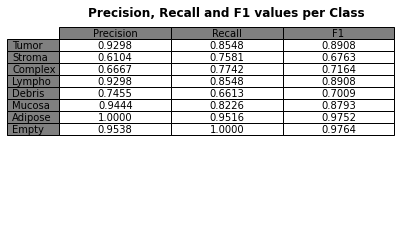

In [ ]:
#3.f Precision, Recall, and F-1 score
#calculate precision, recall, and f1 scores
precision = metrics.precision_score(label_set, prediction_set,average=None)
recall = metrics.recall_score(label_set, prediction_set,average=None)
f1 = metrics.f1_score(label_set, prediction_set,average=None)
#plot
content = np.transpose([precision,recall,f1])
content = [['%.4f' % j for j in i] for i in content]
fig, ax = plt.subplots()
ax.set_axis_off() 
table = ax.table( 
    cellText = content,  
    rowLabels = classes,  
    colLabels = ['Precision','Recall','F1'], 
    rowColours =["grey"] * 8,  
    colColours =["grey"] * 3, 
    cellLoc ='center',  
    loc ='upper center')         
ax.set_title('Precision, Recall and F1 values per Class', 
             fontweight ="bold") 

##

Generate explanation map

# SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [ ]:
layers=[['conv2d_3']]

In [ ]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 4.15 s, sys: 124 ms, total: 4.28 s
Wall time: 2.48 s


# Grad-CAM (Gradient-based Class Activation Mapping)

In [ ]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 635 ms, sys: 80.3 ms, total: 715 ms
Wall time: 493 ms


# RISE (Randomized Input Sampling for Explanation)

In [ ]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1min 42s, sys: 1.69 s, total: 1min 44s
Wall time: 55.7 s


# SHAP

In [ ]:
#import libraries to handle linear regression and computation of combinations
from sklearn.linear_model import LinearRegression
from math import factorial

#Compute n choose k, used for weighting factors
def comb(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

#My SHAP function for HMT
def my_shap(inputs, labels, model, index):
  #Identify input being evaluated
  input = inputs[index]
  label = labels[index]
  #Specify Number of features, create super cells
  M = 49
  #Create arrays to feed into linear regression
  # x is the coalition vector
  x = []
  # y is the prediction based on the coalition vector
  y = []


  # create all coalition vectors to be sampled
  for b in range(M):
    # initialize coalition vector
    feat = np.zeros(M)
    # set one (b-th) feature on
    feat[b] = 1
    # compile coalition vectors including only the bth feature and excluding only the bth feature
    x.append(feat)
    x.append(1 - feat)


  # get predictions for all coalition vectors from the model
  for e in range(np.shape(x)[0]):
    # if the feature is included, sample feature from the input being evaluated
    # if the feature is not included (else), zero out the rest of the image
    # fill input vector
    temp = x[e].reshape(7,7)
    temp = np.kron(temp,np.ones((32,32)))
    temp = np.dstack((temp,temp,temp))
    new_input = np.multiply(temp,input)

    # generate prediction for the new input vector
    pred = model.predict(np.expand_dims(new_input, axis=0))
    # compile predictions into array
    y.append(pred)

  # fix dimensions of array to work with linear regression
  y = np.asarray(y)
  y = y[:,:,label.argmax()]
  
  # create weight vector
  pie = np.zeros(np.shape(x)[0])

  # calculate weights
  for p in range(pie.size):
    #scaling factor to make factorial computable
    z_prime = sum(x[p])
    pie[p] = (M-1) / (z_prime * (M - z_prime) * comb(M, z_prime))

  # find linear regression between predictions and coalition vectors, with weightings
  shap = LinearRegression().fit(x,y,pie)

  ## create explanation map, create 224 x 224 representation
  exmap = shap.coef_
  exmap -= np.min(exmap)
  exmap /= np.max(exmap)
  exmap = exmap.reshape(7,7)
  exmap = np.kron(exmap,np.ones((32,32)))
  
  return exmap

In [ ]:
%%time
explanation_map_SHAP = my_shap(image_batch, label_batch, model, index) 
explanation_map_SHAP -= explanation_map_SHAP.min()
explanation_map_SHAP /= explanation_map_SHAP.max()+10e-30

CPU times: user 15.4 s, sys: 1.07 s, total: 16.5 s
Wall time: 11.8 s


# Plot the results

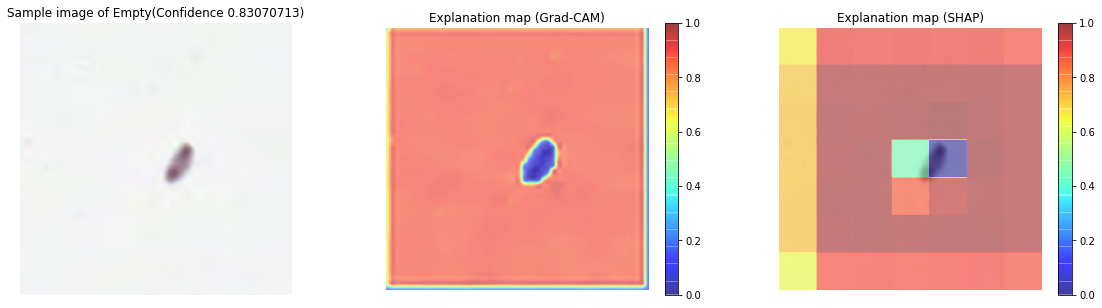

In [ ]:
#Plotting Explanation Maps
# Sample test set
test_generator.reset()
for i in range(15):
  image_batch,label_batch=test_generator.next()
index=20
prediction=model(image_batch)

# calculate gradcam exmap
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

#calculate shap exmap
explanation_map_SHAP = my_shap(image_batch, label_batch, model, index) 
explanation_map_SHAP -= explanation_map_SHAP.min()
explanation_map_SHAP /= explanation_map_SHAP.max()+10e-30

#plot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image of ' + classes[label_batch[index].argmax()]+'(Confidence ' +str(prediction[index][np.argmax(label_batch[index])].numpy())+')')

plt.subplot(1,3,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SHAP, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SHAP)')
plt.colorbar()

# Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for i in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    for index in range(32): 
        #explanation_map = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        explanation_map =  grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        #explanation_map = my_shap(image_batch, label_batch, model, index)
        temp = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate += temp[0]
        if temp[1] :
          increase_rate += 1
drop_rate /= (15*32)
increase_rate /= (15*32)
print(drop_rate)
print(increase_rate)

0.4893244288812479
0.29583333333333334
